In [1]:
questionnaire_attributes = ["INDEPEND", "PERSCARE", "SHOPPING", "TRAVEL", "GAMES", "TAXES", "ORIENT", "NACCMOTF", "MOMODE", "DEMENTED", "MEMORY", "COGFLUC", "EVENTS", "PAYATTN"]
target_var = "NPADNC"

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [77]:
df_all = pd.read_csv("data/data.csv")

In [78]:
df_q = df_all[questionnaire_attributes + [target_var]]

In [79]:
# remove attributes with too many NaNs - more than 50%
attributes_nans = df_q.apply(lambda col: sum(np.isnan(col)))
attributes_filled = attributes_nans[attributes_nans < len(attributes_nans)/2].index.values
df_q = df_q[attributes_filled]

# replace values of (Not assessed, Missing/unknown, not collected) with interpolated values
attributes_uniques = df_q.applymap(str).describe().transpose()["unique"]
weird_attributes = ['SMOKYRS', 'PACKSPER', 'NACCBMI', 'NACCGDS', 'BEREMAGO', 'PARKAGE', "BEVHAGO"]
replaced_attributes = attributes_uniques[attributes_uniques < 8].index.values.tolist()
df_q[replaced_attributes] = df_q[replaced_attributes].replace([-4, 8, 9], np.nan)

In [80]:
# balance the target groups in data set to minimal one
from sklearn.utils import resample

cat_dfs = [df_q[df_q[target_var] == 1],
           df_q[df_q[target_var] == 2],
           df_q[df_q[target_var] == 3]]

top_counts = df_q[target_var].value_counts().values[0]

dfs_upsampled = map(lambda minor_df: resample(minor_df, replace=True, n_samples=top_counts, random_state=321), cat_dfs)
dfs_upsampled.append(resample(df_q[df_q[target_var] == 0], replace=True, n_samples=top_counts*2, random_state=321))
df_upsampled = pd.concat(dfs_upsampled)
df_upsampled["NPADNC"].value_counts()

0.0    6744
3.0    3372
2.0    3372
1.0    3372
Name: NPADNC, dtype: int64

In [81]:
df_q = df_upsampled

In [82]:
df_q[target_var].value_counts().values[0]

6744

In [83]:
# drop NaNs in target variable
df_q = df_q[pd.notnull(df_q["NPADNC"])]

# apply the interpolation on the attributes with surrounding data
interpolated_selected = df_q.interpolate(axis=1)

# set non-interpolated values to zero
# required for classification and t/chi importance test to have all values filled
interpolated_selected.index = np.arange(len(interpolated_selected.index))
non_interpolated_coords = np.argwhere(~np.isfinite(interpolated_selected.values))
interpolated_selected.ix[np.transpose(non_interpolated_coords)[0], np.transpose(non_interpolated_coords)[1]] = 0
interpolated_selected.index = df_q.index

df_q[questionnaire_attributes] = interpolated_selected[questionnaire_attributes]

In [84]:
df_q.head()

,INDEPEND,PERSCARE,SHOPPING,TRAVEL,GAMES,TAXES,ORIENT,NACCMOTF,MOMODE,DEMENTED,MEMORY,COGFLUC,EVENTS,PAYATTN,NPADNC
9599,2.0,0.0,1.0,1.0,2.0,3.0,0.5,1.0,1.0,1.0,1.0,1.000,1.00,1.000,1.0
2314,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.000,1.0
12305,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.000,1.0
12347,1.0,1.0,2.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,1.0,0.500,0.00,0.000,1.0
10921,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.625,0.75,0.875,1.0


## Machine learning estimators

We have decided to experiment and evaluate a few selected methods of the various sort:

* LDA

* Logistic Regression

* Bayesian Classifier

* Decision trees (Random Decision Forrest)


In [96]:
from sklearn.model_selection import StratifiedKFold

X = df_q[list(set(df_q.columns) - set([target_var]))]
y = df_q[target_var]

results = dict()

In [86]:
list(set(df_q.columns) - set([target_var]))

['NACCMOTF',
 'SHOPPING',
 'COGFLUC',
 'TRAVEL',
 'INDEPEND',
 'TAXES',
 'ORIENT',
 'DEMENTED',
 'GAMES',
 'MEMORY',
 'PAYATTN',
 'PERSCARE',
 'EVENTS',
 'MOMODE']

In [97]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as Classifier
method = "LDA"

In [109]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression as Classifier
method = "Logistic Regression"

In [101]:
# Bayesian Classifier
from sklearn.naive_bayes import MultinomialNB as Classifier
method = "Naive Bayes"

In [112]:
# Tree Ensemble Classifier
from sklearn.ensemble import RandomForestClassifier as Classifier
method = "Random Forrest"

In [105]:
from sklearn.linear_model import SGDClassifier as Classifier
method = "SGDClassifier"

In [113]:
results[method] = []
for train_coords, test_coords in StratifiedKFold(n_splits=10, shuffle=True).split(X ,y):
    classifier = Classifier()
    classifier.fit(X.iloc[train_coords], y.iloc[train_coords])
    accuracy = classifier.score(X.iloc[test_coords], y.iloc[test_coords])
    print accuracy
    results[method].append(accuracy)
print "\n%s" % np.average(results[method])

0.766725873298
0.750740082889
0.750889679715
0.743772241993
0.757270029674
0.743026706231
0.760830860534
0.747774480712
0.756676557864
0.752522255193

0.75302287681


In [114]:
# model persistence support
from sklearn.externals import joblib
joblib.dump(classifier, "random_forrest_classifier.mod")

['random_forrest_classifier.mod']

In [59]:
# Baseline
results["Baseline (Random)"] = [0.25 for _ in range(10)]

In [60]:
results_df = pd.DataFrame(results)

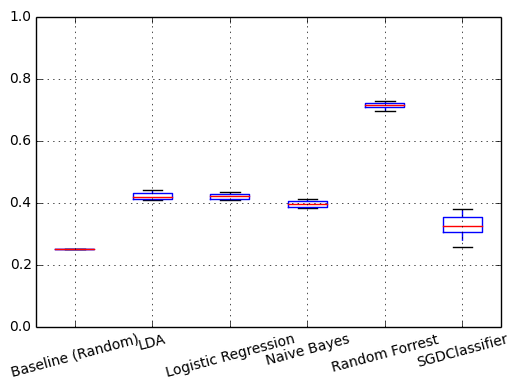

In [108]:
axes = plt.gca()
axes.set_ylim([0,1])
results_df.boxplot(figsize=(12, 3), rot=15)

In [62]:
df_all.groupby(by="NPADNC").count()["NACCMOTF"]

NPADNC
-4    6518
 0     545
 1     829
 2    1291
 3    3372
 8      58
 9      16
Name: NACCMOTF, dtype: int64

In [21]:
df_all["NPADNC"].count()

12629